In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import os, sys
cwd = os.getcwd()

api_path_toy = os.path.join(cwd, '..', 'tools', 'toy_examples_utils')
#api_path_sir = os.path.join(cwd, '..', 'tools', 'sir_ais_sampling')
models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
#models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'wasserstein')
sys.path.append(api_path_toy)
#sys.path.append(api_path_sir)
sys.path.append(os.path.join(cwd, '..', 'tools', 'sampling_utils'))

In [98]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
import importlib
from tqdm import tqdm

import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from toy_examples_utils import (prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           plot_fake_data_projection,
                           plot_discriminator_2d,
                           plot_potential_energy,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           #xtry_langevin_sampling_plot_2d,
                           epoch_visualization,
                           plot_chain_metrics)
from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          mala_sampling,
                          #xtry_langevin_sampling,
                          tempered_transitions_sampling,
                          gan_energy)

from adaptive_mc import adaptive_sir_correlated_dynamics, ex2_mcmc_mala
from adaptive_sir_loss import *

from flows import RNVP


from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

from params_25gaussians import (sigma,
                                random_seed,
                                train_dataset_size,
                                n_dim,
                                n_layers_d,
                                n_layers_g,
                                n_hid_d,
                                n_hid_g,
                                n_out,
                                device)

from general_utils import DotDict

from metrics import Evolution

In [99]:
from pathlib import Path
figpath = Path('../figs')

# 2D Gaussians, true distribution

In [100]:
from sklearn.preprocessing import StandardScaler

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [101]:
n_dim = 5
target_args = DotDict()
target_args.device = device
target_args.num_gauss = 25
n_col = 5
n_row = target_args.num_gauss // n_col
s = 1
###create points
coef_gaussian = 1./target_args.num_gauss
target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
locs = [torch.tensor([(i-2)*s,(j-2)*s] + [0]* (n_dim - 2)).to(device) 
        for i in range(n_col) for j in range(n_row)]
target_args.locs = locs
target_args.covs = [(sigma**2)*torch.eye(n_dim).to(device)]*target_args.num_gauss
target_args.dim = n_dim
true_target = Gaussian_mixture(target_args).log_prob


loc_proposal = torch.zeros(n_dim).to(device)
scale_proposal = 3*torch.ones(n_dim).to(device)
proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(proposal_args)

In [102]:
evols = dict()

In [103]:
true_target_energy = Gaussian_mixture(target_args).energy

x_range = 3.0
y_range = 3.0
norm_grads = False
# plot_potential_energy(true_target_energy,
#                       x_range,
#                       y_range,
#                       device,
#                       norm_grads = norm_grads,
#                       num_points = 100)

In [104]:
batch_size_sample = 5000

In [105]:
loss = "mix_kl" 

        



In [106]:
loss_function = get_loss(loss)

In [107]:
?loss_function

Signature: loss_function(target, proposal, flow, y, alpha=0.99)
Docstring: <no docstring>
File:      ~/Documents/GitCodes/gans_sampling/tools/sampling_utils/adaptive_sir_loss.py
Type:      function


In [108]:
?get_loss

Signature: get_loss(loss)
Docstring: <no docstring>
File:      ~/Documents/GitCodes/gans_sampling/tools/sampling_utils/adaptive_sir_loss.py
Type:      function


In [109]:
flow = RNVP(num_flows = 1, dim = n_dim )

In [110]:
params = flow.parameters()

In [111]:
optimizer = get_optimizer(params, optimizer = "Adam", lr = 1e-4)

In [112]:
batch_size = 400

z_0 = proposal.sample((batch_size,))

In [113]:
z_0.shape

torch.Size([400, 5])

In [114]:
N_optim = 1000
alpha = 0.1
n_steps = 1
N = 5

z_ = z_0.clone()
for i in tqdm(range(N_optim)):
    
    zl = adaptive_sir_correlated_dynamics(z_, true_target, proposal, n_steps, N, alpha, flow)
    z_ = zl[-1]
    loss, grad_loss = loss_function(true_target, proposal, flow, z_)
    if i%25 == 0:
        print(loss)
    grad_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 1/1000 [00:00<02:20,  7.13it/s]

tensor(-2276.1670, grad_fn=<AddBackward0>)


  3%|▎         | 27/1000 [00:02<01:14, 13.09it/s]

tensor(-1453.1104, grad_fn=<AddBackward0>)


  5%|▌         | 53/1000 [00:04<01:07, 13.94it/s]

tensor(-1427.7324, grad_fn=<AddBackward0>)


  8%|▊         | 77/1000 [00:05<01:06, 13.87it/s]

tensor(-1425.8235, grad_fn=<AddBackward0>)


 10%|█         | 103/1000 [00:07<00:57, 15.53it/s]

tensor(-1411.3051, grad_fn=<AddBackward0>)


 13%|█▎        | 127/1000 [00:09<00:52, 16.56it/s]

tensor(-1352.9431, grad_fn=<AddBackward0>)


 15%|█▌        | 153/1000 [00:10<01:01, 13.80it/s]

tensor(-1347.8124, grad_fn=<AddBackward0>)


 18%|█▊        | 177/1000 [00:12<00:57, 14.30it/s]

tensor(-1367.4609, grad_fn=<AddBackward0>)


 20%|██        | 203/1000 [00:14<00:55, 14.47it/s]

tensor(-1348.5027, grad_fn=<AddBackward0>)


 23%|██▎       | 227/1000 [00:16<00:58, 13.25it/s]

tensor(-1301.2227, grad_fn=<AddBackward0>)


 25%|██▌       | 253/1000 [00:18<00:57, 12.91it/s]

tensor(-1256.6647, grad_fn=<AddBackward0>)


 28%|██▊       | 277/1000 [00:20<00:52, 13.87it/s]

tensor(-1287.0387, grad_fn=<AddBackward0>)


 30%|███       | 303/1000 [00:21<00:45, 15.16it/s]

tensor(-1268.5155, grad_fn=<AddBackward0>)


 33%|███▎      | 327/1000 [00:23<00:48, 13.99it/s]

tensor(-1207.2965, grad_fn=<AddBackward0>)


 35%|███▌      | 353/1000 [00:25<00:48, 13.23it/s]

tensor(-1100.1736, grad_fn=<AddBackward0>)


 38%|███▊      | 377/1000 [00:27<00:42, 14.59it/s]

tensor(-1183.3584, grad_fn=<AddBackward0>)


 40%|████      | 403/1000 [00:28<00:40, 14.81it/s]

tensor(-1103.3927, grad_fn=<AddBackward0>)


 43%|████▎     | 427/1000 [00:30<00:42, 13.34it/s]

tensor(-1013.4418, grad_fn=<AddBackward0>)


 45%|████▌     | 453/1000 [00:32<00:38, 14.17it/s]

tensor(-1039.4509, grad_fn=<AddBackward0>)


 48%|████▊     | 477/1000 [00:34<00:39, 13.37it/s]

tensor(-1021.4656, grad_fn=<AddBackward0>)


 50%|█████     | 503/1000 [00:36<00:36, 13.43it/s]

tensor(-977.6055, grad_fn=<AddBackward0>)


 53%|█████▎    | 527/1000 [00:37<00:33, 14.18it/s]

tensor(-995.7147, grad_fn=<AddBackward0>)


 55%|█████▌    | 553/1000 [00:39<00:32, 13.70it/s]

tensor(-945.1387, grad_fn=<AddBackward0>)


 58%|█████▊    | 577/1000 [00:41<00:30, 14.00it/s]

tensor(-983.3809, grad_fn=<AddBackward0>)


 60%|██████    | 603/1000 [00:43<00:29, 13.42it/s]

tensor(-849.5649, grad_fn=<AddBackward0>)


 63%|██████▎   | 627/1000 [00:45<00:30, 12.28it/s]

tensor(-834.9923, grad_fn=<AddBackward0>)


 65%|██████▌   | 653/1000 [00:47<00:25, 13.84it/s]

tensor(-841.1766, grad_fn=<AddBackward0>)


 68%|██████▊   | 677/1000 [00:49<00:25, 12.78it/s]

tensor(-757.5186, grad_fn=<AddBackward0>)


 70%|███████   | 703/1000 [00:51<00:22, 13.04it/s]

tensor(-804.8226, grad_fn=<AddBackward0>)


 73%|███████▎  | 727/1000 [00:53<00:19, 14.21it/s]

tensor(-766.6886, grad_fn=<AddBackward0>)


 75%|███████▌  | 753/1000 [00:54<00:18, 13.04it/s]

tensor(-760.6291, grad_fn=<AddBackward0>)


 78%|███████▊  | 777/1000 [00:56<00:17, 13.03it/s]

tensor(-660.3873, grad_fn=<AddBackward0>)


 80%|████████  | 803/1000 [00:58<00:14, 13.15it/s]

tensor(-668.3739, grad_fn=<AddBackward0>)


 83%|████████▎ | 829/1000 [01:00<00:10, 15.66it/s]

tensor(-702.9079, grad_fn=<AddBackward0>)


 85%|████████▌ | 853/1000 [01:02<00:09, 15.00it/s]

tensor(-578.4929, grad_fn=<AddBackward0>)


 88%|████████▊ | 877/1000 [01:04<00:08, 14.49it/s]

tensor(-551.7443, grad_fn=<AddBackward0>)


 90%|█████████ | 903/1000 [01:05<00:06, 14.96it/s]

tensor(-505.0829, grad_fn=<AddBackward0>)


 93%|█████████▎| 927/1000 [01:07<00:06, 11.57it/s]

tensor(-483.5449, grad_fn=<AddBackward0>)


 95%|█████████▌| 953/1000 [01:09<00:03, 13.94it/s]

tensor(-457.4539, grad_fn=<AddBackward0>)


 98%|█████████▊| 977/1000 [01:11<00:01, 14.10it/s]

tensor(-408.8719, grad_fn=<AddBackward0>)


100%|██████████| 1000/1000 [01:12<00:00, 13.78it/s]


In [115]:
zl = adaptive_sir_correlated_dynamics(zl[-1], true_target, proposal, 1000, N, alpha, flow)

adaptive_sir_correlated_dynamics(z, target, proposal, n_steps, N, alpha, flow)

In [116]:
array = []
for s in zl:
    s=s.detach().numpy()
    array.append(s)
np.array(array).shape

(1001, 400, 5)

In [117]:
X_train = np.array(array).reshape(-1,2)

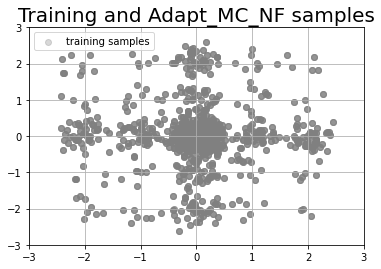

In [118]:
plt.figure()
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)
plt.title(f"Training and Adapt_MC_NF samples", fontsize=20)
plt.scatter(X_train[-5000:,:1], X_train[-5000:,1], alpha=0.3, color='gray', 
            marker='o', label = 'training samples')
label = 'Adapt_MC_NF samples'

#plt.scatter(fake[:,:1], fake[:,1:], alpha=0.3, color='blue', 
#            marker='o', label = label)
plt.legend()
plt.grid(True)
plt.show()

In [124]:
flow = RNVP(num_flows = 4, dim = n_dim )
optimizer = get_optimizer(flow.parameters(), optimizer = "Adam", lr = 1e-4)
z_0 = proposal.sample((batch_size,))

N_optim = 1000
n_steps = 1
N = 5
mala_steps = 3
grad_step = 1e-2
noise_scale = (2 * grad_step)**.5
corr_coef = 0.9
bernoulli_prob_corr = 0.75

z_ = z_0.clone()
for i in tqdm(range(N_optim)):
    
    zl, acceptance = ex2_mcmc_mala(z_, true_target, proposal, n_steps, N, 
                        grad_step=grad_step, noise_scale=noise_scale, mala_steps = mala_steps,
                        corr_coef=corr_coef, bernoulli_prob_corr=bernoulli_prob_corr, flow=flow)
    z_ = zl[-1]
    #print(z_)
    loss, grad_loss = loss_function(true_target, proposal, flow, z_)
    if i%25 == 0:
        print(loss)
    grad_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 1/1000 [00:00<06:41,  2.49it/s]

tensor(-5828.1509, grad_fn=<AddBackward0>)


  3%|▎         | 26/1000 [00:11<07:41,  2.11it/s]

tensor(-4820.7700, grad_fn=<AddBackward0>)


  5%|▌         | 51/1000 [00:21<06:29,  2.44it/s]

tensor(-4591.8481, grad_fn=<AddBackward0>)


  8%|▊         | 76/1000 [00:32<06:05,  2.53it/s]

tensor(-4397.6729, grad_fn=<AddBackward0>)


 10%|█         | 101/1000 [00:43<05:57,  2.51it/s]

tensor(-3862.5151, grad_fn=<AddBackward0>)


 13%|█▎        | 126/1000 [00:54<06:02,  2.41it/s]

tensor(-3887.3406, grad_fn=<AddBackward0>)


 15%|█▌        | 151/1000 [01:04<05:54,  2.40it/s]

tensor(-3207.6523, grad_fn=<AddBackward0>)


 15%|█▌        | 152/1000 [01:05<06:04,  2.33it/s]


KeyboardInterrupt: 

In [125]:
zl, _ = ex2_mcmc_mala(zl[-1], true_target, proposal, 100, N, 
                        grad_step=grad_step, noise_scale=noise_scale, 
                        corr_coef=corr_coef, bernoulli_prob_corr=bernoulli_prob_corr, flow=flow)

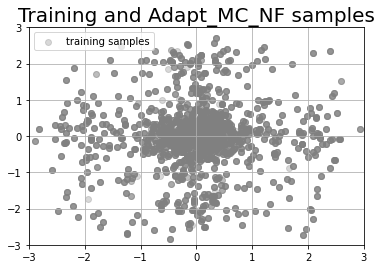

In [129]:
array = []
for s in zl:
    s=s.detach().numpy()
    array.append(s)
np.array(array).shape

X_train = np.array(array).reshape(-1,2)

plt.figure()
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)
plt.title(f"Training and Adapt_MC_NF samples", fontsize=20)
plt.scatter(X_train[-5000:,:1], X_train[-5000:,1], alpha=0.3, color='gray', 
            marker='o', label = 'training samples')
label = 'Adapt_MC_NF samples'

#plt.scatter(fake[:,:1], fake[:,1:], alpha=0.3, color='blue', 
#            marker='o', label = label)
plt.legend()
plt.grid(True)
plt.show()